# Globals

In [330]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [331]:
global_var = {
    # Resolutions
    'RGB_img_res': (3, 16, 64), # Tensor.shape = [Batch, Channel, Height, Width]
    'patch_size' : 32,

    # Parameters
    'batch_size': 8,
    'eval_batch_size': 1,
    'n_workers': 2,
    'lr': 2e-3,
    'epochs': 100,
    'n_workers': 2,

    # Operations
    'do_print_model': True,
    'use_full_dataset': True,
    'verbose': True,
}

In [332]:
dataset_root = '/content/drive/MyDrive/NN_project/SSID_dataset/'
full_dataset_root = '/content/drive/MyDrive/NN_project/Full_SSID_dataset/'
save_model_root = '/content/drive/MyDrive/NN_project/'
model_name = "Uformer"

# Imports

In [333]:
!pip install einops torchsummaryX --quiet

In [334]:
import cv2
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as TT

from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchsummaryX import summary
from tqdm import tqdm

# Utils

In [335]:
def compute_accuracy(y_pred, y_true, thr=0.05):
  valid_mask = y_true > 0.0
  valid_pred = y_pred[valid_mask]
  valid_true = y_true[valid_mask]
  correct = torch.max((valid_true / valid_pred), (valid_pred / valid_true)) < (1 + thr)
  return 100 * torch.mean(correct.float())

def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
      return param_group['lr']

def hardware_check():
  device = "cuda:0" if torch.cuda.is_available() else "cpu"
  print("Actual device: ", device)
  return device

def load_pretrained_model(model, device):
  print("Loading checkpoint...\n")
  model_dict = torch.load(save_model_root+"/Uformer_best_acc", map_location=torch.device(device))
  model.load_state_dict(model_dict)
  print("Checkpoint loaded!\n")
  return model

def plot_graph(f, g, f_label, g_label, title, path):
  epochs = range(0, len(f))
  plt.plot(epochs, f, 'b', label=f_label)
  plt.plot(epochs, g, 'orange', label=g_label)
  plt.title(title)
  plt.xlabel('Epochs')
  plt.legend()
  plt.grid('on', color='#cfcfcf')
  plt.tight_layout()
  plt.savefig(path + title + '.pdf')
  plt.close()

def plot_history(history):
  plot_graph(history['train_loss'], history['val_loss'], 'Train Loss', 'Val. Loss', 'TrainVal_loss', save_model_root)
  plot_graph(history['train_acc'], history['val_acc'], 'Train Acc.', 'Val. Acc.', 'TrainVal_acc', save_model_root)

def plot_loss(history,title):
  l_train_list = history['train_loss']
  l_test_list = history['val_loss']
  epochs = range(0, len(global_var['epochs']))

  plt.plot(epochs, l_train_list, 'r', label='Train loss')
  plt.plot(epochs, l_test_list, 'g', label='Test loss')
  plt.title(title)
  plt.xlabel('Epochs')
  plt.grid('on', color='#cfcfcf')
  plt.legend()
  plt.tight_layout()
  plt.savefig(save_model_root + "/" + title + '.pdf')
  plt.close()

def print_model(model, device, input_shape):
  info = summary(model, torch.ones((global_var['batch_size'], input_shape[0], input_shape[1], input_shape[2])).to(device))
  info.to_csv(save_model_root + 'model_summary.csv')

def save_checkpoint(model, name):
  torch.save(model.state_dict(), save_model_root + name)

def save_csv_history(model_name):
  objects = []
  with (open(save_model_root + model_name + '_history.pkl', "rb")) as openfile:
      while True:
          try:
              objects.append(pickle.load(openfile))
          except EOFError:
              break
  df = pd.DataFrame(objects)
  df.to_csv(save_model_root + model_name + '_history.csv', header=False, index=False, sep=" ")

def save_history(history, filepath):
  tmp_file = open(filepath + '.pkl', "wb")
  pickle.dump(history, tmp_file)
  tmp_file.close()

# Data

## Dataset

In [336]:
from tables.index import idx2long
class SSID_Dataset(Dataset):
  def __init__(self, data_root, full=True):
    assert os.path.exists(data_root)
    super(SSID_Dataset, self).__init__()

    self.full_dataset = full
    self.instances_list_path = data_root + "Scene_Instances.txt"
    self.data_directories_path = data_root + "Data/"

    self.img_paths = []
    self.target_paths = []
    self.dataset_size = 0

    instances_list_file = open(self.instances_list_path, 'r')
    data_directories = [self.data_directories_path + elem.strip()+"/" for elem in instances_list_file.readlines()]
    instances_list_file.close()

    for elem in data_directories:
      content = sorted(os.listdir(elem))

      if(self.full_dataset):
        self.target_paths.append(elem+content[0])
        self.target_paths.append(elem+content[1])
        self.img_paths.append(elem+content[2])
        self.img_paths.append(elem+content[3])
      else:
        self.target_paths.append(elem+content[0])
        self.img_paths.append(elem+content[1])

    self.dataset_size = len(self.img_paths)

  def __len__(self):
      return self.dataset_size

  def __getitem__(self, index):
      idx = index % self.dataset_size # Avoid going beyond limits

      raw_noise_img = np.float32(cv2.cvtColor(cv2.imread(self.img_paths[idx]), cv2.COLOR_BGR2RGB))
      noise_img = torch.from_numpy(raw_noise_img).permute(2,0,1)

      raw_gt_img = np.float32(cv2.cvtColor(cv2.imread(self.target_paths[idx]), cv2.COLOR_BGR2RGB))
      gt_img = torch.from_numpy(raw_gt_img).permute(2,0,1)

      ps = global_var['patch_size']
      H = gt_img.shape[1]
      W = gt_img.shape[2]
      # r = np.random.randint(0, H - ps) if not H-ps else 0
      # c = np.random.randint(0, W - ps) if not H-ps else 0
      if H-ps==0:
          r=0
          c=0
      else:
          r = np.random.randint(0, H - ps)
          c = np.random.randint(0, W - ps)
      gt_img = gt_img[:, r:r + ps, c:c + ps]
      noise_img = noise_img[:, r:r + ps, c:c + ps]

      return noise_img, gt_img

## Dataloader

In [337]:
if(global_var['use_full_dataset']):
  dataset = SSID_Dataset(full_dataset_root)
  print("Using full SSID dataset with %d samples" % dataset.__len__())
  train_dataset, test_dataset = random_split(dataset, [256, 64])

else:
  dataset = SSID_Dataset(dataset_root,False)
  print("Using partial SSID dataset with %d samples" % dataset.__len__())
  train_dataset, test_dataset = random_split(dataset, [128, 32])

train_loader = DataLoader(dataset=train_dataset,
                          batch_size = global_var['batch_size'],
                          num_workers = global_var['n_workers'],
                          shuffle = True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size = global_var['eval_batch_size'],
                         num_workers = global_var['n_workers'],
                         shuffle = True)

print("Train size: ", len(train_dataset))
print("Test size: ", len(test_dataset))
print("Train data percentage: ", len(train_dataset)/(len(train_dataset)+len(test_dataset)))
print("Test data percentage: ", len(test_dataset)/(len(train_dataset)+len(test_dataset)))

Using full SSID dataset with 320 samples
Train size:  256
Test size:  64
Train data percentage:  0.8
Test data percentage:  0.2


# Loss

In [338]:
# class Cha_loss(nn.Module):
#   def __init__(self, epsilon=1e-3):
#     super(Cha_loss,self).__init__()
#     self.epsilon = epsilon

#   def forward(self,pred,truth):
#     return torch.mean(torch.sqrt((pred-truth)**2 + self.epsilon**2))

class Cha_loss(nn.Module):
    """Charbonnier Loss (L1)"""
    def __init__(self, eps=1e-6):
        super(Cha_loss, self).__init__()
        self.eps = eps

    def forward(self, x, y):
        b, c, h, w = y.size()
        loss = torch.sum(torch.sqrt((x - y).pow(2) + self.eps**2))
        return loss/(c*b*h*w)

# Evaluation metrics

In [348]:
# ATTENTION: PYTORCH HAS PIXEL RANGE BETWEEN 0.0 AND 1.0, NOT BETWEEN 0 AND 255
# It works, compared with torchmetrics.image import PeakSignalNoiseRatio
def psnr(original_img, compressed_img, max_pix_val=255):
  mse = torch.mean((original_img-compressed_img)**2)
  return 20 * torch.log10(max_pix_val/torch.sqrt(mse))

def gaussian(window_size, sigma):
    gauss = torch.Tensor([math.exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel=1):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window

# ATTENTION: PYTORCH HAS PIXEL RANGE BETWEEN 0.0 AND 1.0, NOT BETWEEN 0 AND 255
# ATTENTION: 4D tensors needed
# It works, compared with StructuralSimilarityIndexMeasure from torchmetrics.image
def ssim(original_img, restored_img, max_pix_val=255, window_size=11, window=None, size_average=True, full=False):
    (_, channel, height, width) = original_img.size()
    real_size = min(window_size, height, width)
    window = create_window(real_size, channel=channel).to(original_img.device)

    mu1 = F.conv2d(original_img, window, padding=0, groups=channel)
    mu2 = F.conv2d(restored_img, window, padding=0, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(original_img ** 2, window, padding=0, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(restored_img ** 2, window, padding=0, groups=channel) - mu2_sq
    sigma12 = F.conv2d(original_img * restored_img, window, padding=0, groups=channel) - mu1_mu2

    C1 = (0.01 * max_pix_val) ** 2
    C2 = (0.03 * max_pix_val) ** 2

    v1 = 2.0 * sigma12 + C2
    v2 = sigma1_sq + sigma2_sq + C2

    return (((2 * mu1_mu2 + C1) * v1) / ((mu1_sq + mu2_sq + C1) * v2)).mean()


def compute_evaluation(test_dataloader, model, device='cpu'):
  model.eval()
  psnr_values = []
  ssim_values = []

  for _, (inputs, targets) in enumerate(test_dataloader):
      inputs, targets = inputs.to(device), targets.to(device)

      with torch.no_grad():
          predictions = model(inputs)

      psnr_values.append(psnr(targets,predictions))
      ssim_values.append(ssim(targets,predictions))

  return torch.mean(torch.Tensor(psnr_values)).item(),torch.mean(torch.Tensor(ssim_values)).item()

# Architecture

In [340]:
# Attention components
# attention module
# Attention module with window attention
class W_MSA(nn.Module):
  def __init__(self, dim=32, num_heads=8, qkv_bias=False):
    super(W_MSA, self).__init__()
    self.num_heads = num_heads
    self.head_dim = dim // num_heads
    self.dim = dim

    # nn.Linear(in_features, out_features): the input of the layer has to have the last dimension equal to in_features (namely (*, in_features)). The output of the layer has the
    # same dimension of the input except for the last one which is equal to out_features (namely (*, out_features))

    # self.qkv = nn.Linear(dim, num_heads, self.head_dim, bias=qkv_bias) # this layer returns the queries, keys and values
    self.qkv = nn.Linear(dim, self.head_dim*self.num_heads*3, bias=qkv_bias)

    # these are default layers for the attention module
    self.proj = nn.Linear(dim, dim)
    self.proj_drop = nn.Dropout(0.)
    self.attn_drop = nn.Dropout(0.)

  def forward(self, x):
    B, N, C = x.shape
    # print("********* x shape: ",x.shape)
    # print("********* self qkv shape:",self.qkv(x).shape)

    # feature map split
    H = int(math.sqrt(N))
    W = int(math.sqrt(N))
    M = 2 # choosen arbitrarily
    # torch.split(x, M**2)
    # attentions_tensor = torch.zeros((H*W)//(M**2))
    attentions_tensor = []
    splitted = torch.split(x, M**2)
    # print("************************** total len: ", len(splitted))
    for i in range(len(splitted)):
      # print("************************** i: ", i)
      # print("************************** item shape: ", splitted[i].shape)
      b, n, c = splitted[i].shape
      qkv_temp = self.qkv(splitted[i].flatten(2))
      mult = qkv_temp.shape[0] * qkv_temp.shape[1] * qkv_temp.shape[2]
      mult = mult//3
      mult = mult//(self.num_heads*4)

      if(B==global_var['batch_size']):
        mult = mult//global_var['batch_size']
      else:
        mult = mult//global_var['eval_batch_size']

      qkv = qkv_temp.reshape(B, mult, self.num_heads*4, 3)
      q, k, v = qkv.unbind(dim=-1) # this returnes a tuple of tensors whose each element is portion of the original tensor (qkv) (ref: https://pytorch.org/docs/stable/generated/torch.unbind.html)

      scale = (C // self.head_dim) ** (0.5)
      attn = ((q @ k.transpose(-2, -1)) // scale) + B # from the github: the final B can be also removed
      attn = attn.softmax(dim=1)
      attn = self.attn_drop(attn)
      x = (attn @ v).transpose(1, 2).reshape(b, n, c)

      # attentions_tensor.add(x)
      attentions_tensor.append(x)

    x = attentions_tensor[0]
    for i, t in enumerate(attentions_tensor):
      if (i == 0):
        continue
      x = torch.cat([attentions_tensor[i], x], -1)

    x = x.reshape([x.shape[0]*(x.shape[2]//self.dim), x.shape[1], x.shape[2]//(x.shape[2]//self.dim)])
    # print("****************************** final x shape:", x.shape)
    x = self.proj(x)
    x = self.proj_drop(x)

    return x



    # qkv_temp = self.qkv(x)
    # mult = qkv_temp.shape[0] * qkv_temp.shape[1] * qkv_temp.shape[2]
    # mult = mult//3
    # mult = mult//(self.num_heads*4)

    # if(B==global_var['batch_size']):
    #   mult = mult//global_var['batch_size']
    # else:
    #   mult = mult//global_var['eval_batch_size']

    # qkv = qkv_temp.reshape(B, mult, self.num_heads*4, 3)
    # # qkv = self.qkv(x).reshape(B, N, self.num_heads*3, C // self.num_heads).permute(2, 0, 3, 1)
    # # print("QKV: ",self.qkv(x).shape)
    # # print("QKV reshaped: ",self.qkv(x).reshape(B, mult, self.num_heads*4, 3).shape)

    # # print("********* qkv shape:",qkv.shape)
    # q, k, v = qkv.unbind(dim=-1) # this returnes a tuple of tensors whose each element is portion of the original tensor (qkv) (ref: https://pytorch.org/docs/stable/generated/torch.unbind.html)

    # # this is the implementation of the attention formula described on the paper
    # scale = (C // self.head_dim) ** (0.5)
    # attn = ((q @ k.transpose(-2, -1)) // scale) + B # from the github: the final B can be also removed
    # attn = attn.softmax(dim=1)
    # attn = self.attn_drop(attn)
    # # print("********** x no reshape:",(attn @ v).transpose(1, 2).shape)
    # x = (attn @ v).transpose(1, 2).reshape(B, N, C)

    # # these are default for the attention module
    # x = self.proj(x)
    # x = self.proj_drop(x)

    # return x

# this is the simple implementation described in the paper
class LeFF(nn.Module):
  def __init__(self, dim=32, hidden_dim=128):
    super(LeFF, self).__init__()
    self.dim = dim
    self.hidden_dim = hidden_dim

    self.layer1 = nn.Sequential(nn.Linear(dim, hidden_dim), nn.GELU())
    self.layer2 = nn.Sequential(nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=1, padding=1), nn.GELU())
    self.layer3 = nn.Sequential(nn.Linear(hidden_dim, dim))

  def forward(self, x):
    # print("Before 1st layer x: ", x.shape)
    x = self.layer1(x)
    x = self.layer2(x.permute(2,1,0))
    x = self.layer3(x.permute(2,1,0))

    return x

  # def forward(self, x):
  #   # bs x hw x c
  #   bs, hw, c = x.size()
  #   hh = int(math.sqrt(hw))

  #   x = self.layer1(x)

  #   # spatial restore
  #   x = rearrange(x, ' b (h w) (c) -> b c h w ', h = hh, w = hh)

  #   x = self.layer2(x)

  #   # flatten
  #   x = rearrange(x, ' b c h w -> b (h w) c', h = hh, w = hh)

  #   x = self.layer3(x)

  #   return x

# NN BLOCKS
# LeWin Transformer Block (from the paper, it is made up of a sequence of: NormLayer, W_MSA, NormLayer, LeFF)
class TransformerBlock(nn.Module):
  def __init__(self, dim):
    super().__init__()
    self.norm1 = nn.LayerNorm(dim)
    self.w_msa = W_MSA(dim=dim)
    self.norm2 = nn.LayerNorm(dim)
    self.leff = LeFF(dim=dim)
    self.dropout = nn.Dropout(0.)

  def forward(self, x):
    x = self.dropout(self.norm1(x))
    x = self.w_msa(x)
    x = self.dropout(self.norm2(x))
    x = self.leff(x)

    return x

# Down-sampling Block (reduces the size of the feature map)
# reshape the flattened features into 2D spatial feature maps, and then down-sample the maps, double the channels using 4 × 4 convolution with stride 2
class DownsampleBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(DownsampleBlock, self).__init__()
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=4, stride=2, padding=1),
        )

    def forward(self, x): # remember that x is a tensor!!
        B, L, C = x.shape
        H = int(math.sqrt(L))
        W = int(math.sqrt(L))
        # print("*************** x: ",x.shape)
        x = x.transpose(1, 2).contiguous().view(B, C, H, W) # this transposes the 1st and 2nd dimension of x, then the size of x is reshaped with view (the new size is (B, C, H, W))
                                                            # (.contiguous() is required to make view workable, since view works only on contiguous data)

        out = self.conv(x).flatten(2).transpose(1, 2).contiguous() # this pass the input x to the downsample layer, then the 2nd dimension of the output is flattened with the 3rd
                                                                   # and finally its 1st and 2nd dimensions are transposed

                                                                   # (B, C, H*W) is the size of the out after flatten(2)
                                                                   # (B H*W C) is the final size of the out after transpose(1, 2)
        return out


# Up-sampling Block (reduces half of the channels and doubles the size of the feature map)
# 2 × 2 transposed convolution with stride 2
class UpsampleBlock(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, stride, padding):
      super(UpsampleBlock, self).__init__()
      self.in_channel = in_channel
      self.out_channel = out_channel
      self.deconv = nn.Sequential(
        nn.ConvTranspose2d(in_channel, out_channel, kernel_size=kernel_size, stride=stride,padding=padding),
      )

    def forward(self, x):
      B, L, C = x.shape
      H = int(math.sqrt(L))
      W = int(math.sqrt(L))
      x = x.transpose(1, 2).contiguous().view(B, C, H, W)
      out = self.deconv(x).flatten(2).transpose(1, 2).contiguous() # B H*W C

      return out

# Input Projection Block (extracts the low-level features)
# 3 x 3 convolutional layer with LeakyReLu
class InputProjBlock(nn.Module):
    def __init__(self, in_channel=3, out_channel=32, kernel_size=3):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=1, padding=kernel_size//2),
            nn.LeakyReLU(0.1)
        )

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2).contiguous()  # B H*W C

        return x

# Output Projection Block (returns the residual)
# 3 x 3 convolutional layer
class OutputProjBlock(nn.Module):
    def __init__(self, in_channel=64, out_channel=3, kernel_size=3):
        super().__init__()
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.proj = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=1, padding=kernel_size//2),
            nn.LeakyReLU(0.1)
        )

    def forward(self, x):
        B, L, C = x.shape
        H = int(math.sqrt(L))
        W = int(math.sqrt(L))
        x = x.transpose(1, 2).view(B, C, H, W)
        x = self.proj(x)

        return x # the output of this block si called residual

# complete uformer class
class Uformer(nn.Module):
  def __init__(self, embed_dim=32):
    super(Uformer, self).__init__()

    # encoder
    self.input_proj = InputProjBlock()

    self.tranformerblock_0 = TransformerBlock(embed_dim)
    self.downsample_0 = DownsampleBlock(embed_dim, embed_dim*2)

    self.tranformerblock_1 = TransformerBlock(embed_dim*2)
    self.downsample_1 = DownsampleBlock(embed_dim*2, embed_dim*4)

    self.tranformerblock_2 = TransformerBlock(embed_dim*4)
    self.downsample_2 = DownsampleBlock(embed_dim*4, embed_dim*8)

    self.tranformerblock_3 = TransformerBlock(embed_dim*8)
    self.downsample_3 = DownsampleBlock(embed_dim*8, embed_dim*16)


    # bottleneck
    self.tranformerblock_4 = TransformerBlock(embed_dim*16)


    # decoder
    self.upsample_0 = UpsampleBlock(embed_dim*16, embed_dim*8,kernel_size=2,stride=2,padding=0)
    self.tranformerblock_5 = TransformerBlock(embed_dim*16)

    self.upsample_1 = UpsampleBlock(embed_dim*16, embed_dim*4,kernel_size=2,stride=2,padding=0)
    self.tranformerblock_6 = TransformerBlock(embed_dim*8)

    self.upsample_2 = UpsampleBlock(embed_dim*8, embed_dim*2,kernel_size=2,stride=2,padding=0)
    self.tranformerblock_7 = TransformerBlock(embed_dim*4)

    self.upsample_3 = UpsampleBlock(embed_dim*4, embed_dim,kernel_size=2,stride=2,padding=0)
    self.tranformerblock_8 = TransformerBlock(embed_dim*2)

    self.output_proj = OutputProjBlock()


  def forward(self, x):
    degraded_image = x # x is the degraded image


    # encoder
    y = self.input_proj(x)
    t0 = self.tranformerblock_0(y)
    d0 = self.downsample_0(t0)
    t1 = self.tranformerblock_1(d0)
    d1 = self.downsample_1(t1)
    t2 = self.tranformerblock_2(d1)
    d2 = self.downsample_2(t2)
    t3 = self.tranformerblock_3(d2)
    d3 = self.downsample_3(t3)


    # bottleneck
    t4 = self.tranformerblock_4(d3)


    # decoder
    u0 = self.upsample_0(t4)
    # print("1) Upsampled in: ",u0.shape)
    # print("1) Skipped in: ",t3.shape)
    skippedconn_0 = torch.cat([u0, t3], -1) # this creates a skipped connection between t3 and t6 (u0 would have to be the input of t5)
    t5 = self.tranformerblock_5(skippedconn_0)

    u1 = self.upsample_1(t5)
    # print("2) Upsampled in: ",u1.shape)
    # print("2) Skipped in: ",t2.shape)
    skippedconn_1 = torch.cat([u1, t2], -1)
    t6 = self.tranformerblock_6(skippedconn_1)

    u2 = self.upsample_2(t6)
    # print("3) Upsampled in: ",u2.shape)
    # print("3) Skipped in: ",t1.shape)
    skippedconn_2 = torch.cat([u2, t1], -1)
    t7 = self.tranformerblock_7(skippedconn_2)

    u3 = self.upsample_3(t7)
    # print("4) Upsampled in: ",u3.shape)
    # print("4) Skipped in: ",t0.shape)
    skippedconn_3 = torch.cat([u3, t0], -1)
    t8 = self.tranformerblock_8(skippedconn_3)

    residual = self.output_proj(t8)


    # final residual summation
    # print("Degraded: ",degraded_image.shape)
    # print("Residual: ",residual.shape)
    restored_image = degraded_image + residual

    return restored_image

# Train

In [341]:
def train(device,model, optimizer,criterion,train_dataloader,test_dataloader):
  # Globals
  history = {'train_loss': [], 'val_loss': []}
  train_loss_list = []
  test_loss_list = []

  if global_var['do_print_model']:
    print_model(model, device, input_shape=[global_var['RGB_img_res'][0],global_var['patch_size'],global_var['patch_size']])
    print('The {} model has: {} trainable parameters'.format(model_name, count_parameters(model)))

  print("--- Start training: {} ---\n".format(model_name))
  # Train

  for epoch in range(global_var['epochs']):
    iter = 1
    model.train(mode=True)
    running_loss = 0

    with tqdm(train_dataloader, unit="step", position=0, leave=True) as tepoch:
      for batch in tepoch:
        tepoch.set_description(f"Epoch {epoch + 1}/{global_var['epochs']} - Training")

        # Load data
        inputs, targets = batch[0].to(device=device), batch[1].to(device=device)

        # Forward
        optimizer.zero_grad()
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, targets)

        # Backward
        loss = torch.clone(loss).detach().requires_grad_(True)
        loss.backward()
        optimizer.step()

        # Evaluation and Stats
        running_loss += loss.item()
        train_loss_list.append(loss.item())

        tepoch.set_postfix({'Loss': running_loss / iter})
        iter += 1

    # Validation
    iter = 1
    model.eval()
    test_loss = 0
    with tqdm(test_dataloader, unit="step", position=0, leave=True) as tepoch:
      for batch in tepoch:
        tepoch.set_description(f"Epoch {epoch + 1}/{global_var['epochs']} - Validation")
        inputs, targets = batch[0].to(device=device), batch[1].to(device=device)

        # Validation loop
        with torch.no_grad():
          outputs = model(inputs)

          # Evaluation metrics

          # Loss
          loss = criterion(outputs, targets)
          test_loss += loss.item()
          test_loss_list.append(loss.item())

          tepoch.set_postfix({'Loss': test_loss / iter})
          iter += 1

        # Update history infos
        history['train_loss'].append(running_loss / len(train_dataloader))
        history['val_loss'].append(test_loss / len(test_dataloader))

        save_history(history, save_model_root + model_name + '_history')
        save_checkpoint(model, model_name + '_best_acc')
        # Empty CUDA cache
        torch.cuda.empty_cache()

        # Save loss for graphs
        np.save(save_model_root + 'train.npy', np.array(train_loss_list))
        np.save(save_model_root + 'test.npy', np.array(test_loss_list))

  print('--- Finished Training ---')
  # save_csv_history(model_name=model_name)
  # plot_history(history)
  # plot_loss(history, title='Loss Trend')

  return history,train_loss_list, test_loss_list

In [342]:
device = hardware_check()

model = Uformer()
model.to(device)

criterion = Cha_loss()
# optimizer = torch.optim.SGD(model.parameters(), lr=global_var['lr'], weight_decay = 0.005, momentum = 0.9)
optimizer = torch.optim.AdamW(model.parameters(), lr=global_var['lr'], betas=(0.9, 0.999), eps=1e-08, weight_decay=0.02)
stats = train(device,model,optimizer,criterion,train_loader,test_loader)

Actual device:  cuda:0


/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


                                                   Kernel Shape  \
Layer                                                             
0_input_proj.proj.Conv2d_0                        [3, 32, 3, 3]   
1_input_proj.proj.LeakyReLU_1                                 -   
2_tranformerblock_0.LayerNorm_norm1                        [32]   
3_tranformerblock_0.Dropout_dropout                           -   
4_tranformerblock_0.w_msa.Linear_qkv                   [32, 96]   
5_tranformerblock_0.w_msa.Dropout_attn_drop                   -   
6_tranformerblock_0.w_msa.Linear_qkv                   [32, 96]   
7_tranformerblock_0.w_msa.Dropout_attn_drop                   -   
8_tranformerblock_0.w_msa.Linear_proj                  [32, 32]   
9_tranformerblock_0.w_msa.Dropout_proj_drop                   -   
10_tranformerblock_0.LayerNorm_norm2                       [32]   
11_tranformerblock_0.Dropout_dropout                          -   
12_tranformerblock_0.leff.layer1.Linear_0             [32, 128

Epoch 13/100 - Validation:  20%|██        | 13/64 [00:08<00:31,  1.60step/s, Loss=11.2]


KeyboardInterrupt: ignored

In [71]:
with open(save_model_root+"stats_patch.pkl", 'wb') as f:
  pickle.dump(stats,f)

with open(save_model_root+"stats_patch.pkl", 'rb') as f:
  data = pickle.load(f)

800


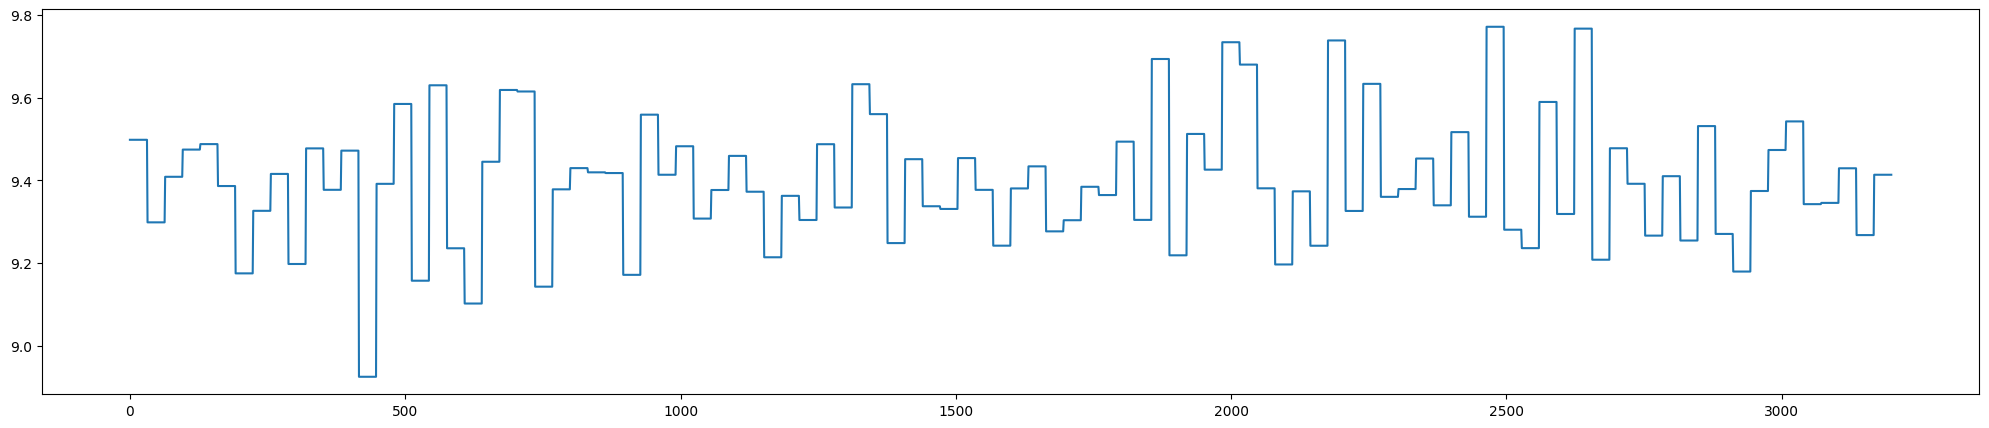

In [76]:
a = data[0]['train_loss']
train_losses = data[4]
test_losses = data[5]

fig, ax = plt.subplots(1, 1, figsize=(25,5))

ax.plot(a)
print(len(train_losses))
# print(len(test_losses))
# train_stats = data[0]
# train_stats.keys()

# train_stats['train_loss']

# fig, ax = plt.subplots(4, 1, figsize=(5,5))
# epochs = torch.linspace(0,global_var['epochs'],steps=960)

# ax[0].set_title("Train loss")
# ax[0].plot(epochs,train_stats['train_loss'], color='orange')
# ax[0].set_ylabel('Loss')
# ax[0].set_xlabel('Epochs')

# ax[1].set_title("Test loss")
# ax[1].plot(epochs,train_stats['val_loss'], color='red')
# ax[1].set_ylabel('Loss')
# ax[1].set_xlabel('Epochs')

# ax[2].set_title("Train accuracy")
# ax[2].plot(epochs,train_stats['train_acc'], color='blue')
# ax[2].set_ylabel('Loss')
# ax[2].set_xlabel('Epochs')

# ax[3].set_title("Test accuracy")
# ax[2].plot(epochs,train_stats['val_acc'], color='green')
# ax[3].set_ylabel('Loss')
# ax[3].set_xlabel('Epochs')

# fig.tight_layout()

# Test

In [349]:
def test(device,test_dataloader):
  model = Uformer()
  model = load_pretrained_model(model,device)
  model.to(device)

  # if global_var['do_print_model']:
  #   print_model(model, device, input_shape=global_var['RGB_img_res'])
    # print('The {} model has: {} trainable parameters'.format(model_name, count_parameters(model)))

  # Evaluate
  print(" --- Begin evaluation --- ")
  mean_psnr, mean_ssim = compute_evaluation(test_dataloader,model,device)
  print(" --- End evaluation --- ")
  print("Mean PSNR: ",mean_psnr)
  print("Mean SSIM: ",mean_ssim)

In [350]:
test(device,test_loader)

Loading checkpoint...

Checkpoint loaded!

 --- Begin evaluation --- 
 --- End evaluation --- 
Mean PSNR:  27.026185989379883
Mean SSIM:  0.483076810836792
